In [1]:
#Import tensorflow

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Test if GPU is found

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
#Autosaving every 10s

%autosave 10

Autosaving every 10 seconds


In [4]:
#Training & Testing files

train_file = "train13.csv"
val_file = "val13.csv"
matlab_file = '1_50_13.mat'
rul_file = "rul_50_13.csv"
fleet_Rul_File = "rul13.csv"
test_file = "test13.csv"

In [5]:
import pandas as pd
import numpy as np
import scipy.io
import tensorflow_probability as tfp
import matplotlib as plt
import matplotlib.pyplot as plt
import pickle
import scipy.io as spio
import pickle
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
tfd = tfp.distributions

In [6]:
# fix random seed for reproducibility

np.random.seed(0)

In [7]:
#load Training & Testing files into Pandas Dataframes

train = pd.read_csv(train_file, index_col=False)
val = pd.read_csv(val_file, index_col=False)
mat = spio.loadmat(matlab_file, squeeze_me=True)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
#Load Hyperparameters Obtained by BayesOpt

lr = mat['lr']
ep = mat['ep']
batch = mat['batch']
pad = mat['Pad']
L2 = mat['L2'] 
unit1 = mat['unit'] 
size1 = mat['size']
drop1 = mat['drop']

lr,ep,batch,pad,L2,unit1,size1,drop1

(0.0005085472898625883, 1e-08, 104, 303, 0.0001, 25, 213, 0.46282080207066145)

In [9]:
#Xtrain to Numpy multidimensional array

xtrain_cut = train.drop(['Fleet','Cycle','RUL'], axis=1)
xtrain = np.zeros((train['Fleet'].max(),pad,xtrain_cut.shape[1]))
for i in range(train['Fleet'].max()):
    df_xtrain = train.loc[train['Fleet']==i+1]
    df_xtrain = df_xtrain.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xtrain = df_xtrain.values
    result = np.zeros((pad,df_xtrain.shape[1]))
    result[:np_xtrain.shape[0],:np_xtrain.shape[1]] = np_xtrain
    xtrain[i] = result
xtrain.shape

(100, 303, 13)

In [10]:
#Ytrain to Numpy multidimensional array

ytrain_cut = train[['RUL']]
ytrain = np.zeros((train['Fleet'].max(),pad,1))
for i in range(train['Fleet'].max()):
    df_ytrain = train.loc[train['Fleet']==i+1]
    df_ytrain = df_ytrain[['RUL']]
    np_ytrain = df_ytrain.values
    result = np.zeros((pad,df_ytrain.shape[1]))
    result[:np_ytrain.shape[0],:np_ytrain.shape[1]] = np_ytrain
    ytrain[i] = result
ytrain.shape

(100, 303, 1)

In [11]:
#Ytrain2 to Numpy multidimensional array - for SHAP

ytrain2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_ytrain2 = train.loc[train['Fleet']==i+1]
    df_ytrain2 = df_ytrain2[['RUL']].values
    ytrain2[i] = df_ytrain2[0]
ytrain2.shape

(100,)

In [12]:
#Xval to Numpy multidimensional array

xval_cut = val.drop(['RUL','Fleet','Cycle'], axis=1)
xval = np.zeros((val['Fleet'].max(),pad,xval_cut.shape[1]))
for i in range(val['Fleet'].max()):
    df_xval = val.loc[val['Fleet']==i+1]
    df_xval = df_xval.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xval = df_xval.values
    result = np.zeros((pad,df_xval.shape[1]))
    result[:np_xval.shape[0],:np_xval.shape[1]] = np_xval
    xval[i] = result
xval.shape

(100, 303, 13)

In [13]:
#Yval to Numpy multidimensional array - for sequential prediction 

yval_cut = val[['RUL']]
yval = np.zeros((val['Fleet'].max(),pad,1))
for i in range(val['Fleet'].max()):
    df_yval = val.loc[val['Fleet']==i+1]
    df_yval = df_yval[['RUL']]
    np_yval = df_yval.values
    result = np.zeros((pad,df_yval.shape[1]))
    result[:np_yval.shape[0],:np_yval.shape[1]] = np_yval
    yval[i] = result
yval.shape

(100, 303, 1)

In [14]:
#Yval2 to Numpy multidimensional array - for SHAP 

yval2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_yval2 = train.loc[train['Fleet']==i+1]
    df_yval2 = df_yval2[['RUL']].values
    yval2[i] = df_yval2[0]
yval2.shape

(100,)

In [15]:
#xtest to Numpy multidimensional array 

test = pd.read_csv(test_file, index_col=False)
xtest_cut = test.drop(['Fleet','Cycle'], axis=1)
xtest = np.zeros((test['Fleet'].max(),pad,xtest_cut.shape[1]))
for i in range(test['Fleet'].max()):
    df_xtest = test.loc[test['Fleet']==i+1]
    df_xtest = df_xtest.drop(['Fleet','Cycle'], axis=1)
    np_xtest = df_xtest.values
    result = np.zeros((pad,df_xtest.shape[1]))
    result[:np_xtest.shape[0],:np_xtest.shape[1]] = np_xtest
    xtest[i] = result

In [16]:
#Verify shapes of array

xtrain.shape,ytrain.shape, ytrain2.shape,xval.shape,yval.shape,yval2.shape,xtest.shape

((100, 303, 13),
 (100, 303, 1),
 (100,),
 (100, 303, 13),
 (100, 303, 1),
 (100,),
 (100, 303, 13))

In [17]:
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
ytrain2 = ytrain2.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
yval2 = yval2.astype(np.float32)
xtest = xtest.astype(np.float32)

In [18]:
#Set ytrain for 3 outputs

x_train = xtrain
y_train = [ytrain,ytrain]
x_val = xval
y_val = [yval,yval]
x_test = xtest

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Reshape
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.models import Model
from IPython.display import display

In [20]:
# Define trainable prior

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [21]:
#Define probabilistic LSTM

#LSTM layers (layer 1,2&3)

inputs = tf.keras.Input(shape=(303,13),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)

#Output 1 = Aleatoric output layer (layer 3&4)

layer3 = Dense(1+1)(layer2)
layer4 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])),name='out1')(layer3) #aleatoric

#Output 2 = Epistemic output layer (layer 5&6)

layer5 = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(layer2)
layer6 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1),name = 'out2')(layer5)

model = tf.keras.Model(inputs=inputs, outputs=[layer4,layer6])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 303, 13)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 303, 25)      3900        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 303, 213)     5538        lstm[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 303, 2)       428         dense[0][0]                      
_______________________________________________________________________________________

In [22]:
#Define directory for best weights checkpoint

import os
checkpoint_path = "C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint/1_50_13_ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Callback for best weights checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [23]:
#Compile model

optimizers.Adam(learning_rate=lr, beta_1 = 0.9,beta_2 = 0.999, epsilon = ep, amsgrad = False, name = "Adam")
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(loss = {'out1': negloglik,'out2': negloglik},loss_weights=[0.5,0.5],optimizer= 'Adam')

In [24]:
#Set Tensorboard  

%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
from tensorflow import keras
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
# Run training on GPU

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10000, batch_size  = batch, verbose = 0, callbacks=[model_checkpoint_callback,tensorboard_callback])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 220.97903, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00002: val_loss improved from 220.97903 to 214.23306, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00003: val_loss did not improve from 214.23306

Epoch 00004: val_loss did not improve from 214.23306

Epoch 00005: val_loss improved from 214.23306 to 212.02669, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00006: val_loss did not improve from 212.02669

Epoch 00007: val_loss improved from 212.02669 to 211.51923, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00008: val_loss improved from 211.51923 to 210.16922, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\


Epoch 00224: val_loss did not improve from 20.70839

Epoch 00225: val_loss did not improve from 20.70839

Epoch 00226: val_loss did not improve from 20.70839

Epoch 00227: val_loss did not improve from 20.70839

Epoch 00228: val_loss did not improve from 20.70839

Epoch 00229: val_loss did not improve from 20.70839

Epoch 00230: val_loss did not improve from 20.70839

Epoch 00231: val_loss did not improve from 20.70839

Epoch 00232: val_loss did not improve from 20.70839

Epoch 00233: val_loss did not improve from 20.70839

Epoch 00234: val_loss did not improve from 20.70839

Epoch 00235: val_loss did not improve from 20.70839

Epoch 00236: val_loss did not improve from 20.70839

Epoch 00237: val_loss did not improve from 20.70839

Epoch 00238: val_loss improved from 20.70839 to 19.85261, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00239: val_loss did not improve from 19.85261

Epoch 00240: val_loss did not improve from 19.85261

Epoch


Epoch 00366: val_loss did not improve from 13.16756

Epoch 00367: val_loss did not improve from 13.16756

Epoch 00368: val_loss improved from 13.16756 to 12.97734, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00369: val_loss did not improve from 12.97734

Epoch 00370: val_loss did not improve from 12.97734

Epoch 00371: val_loss did not improve from 12.97734

Epoch 00372: val_loss did not improve from 12.97734

Epoch 00373: val_loss did not improve from 12.97734

Epoch 00374: val_loss did not improve from 12.97734

Epoch 00375: val_loss did not improve from 12.97734

Epoch 00376: val_loss did not improve from 12.97734

Epoch 00377: val_loss did not improve from 12.97734

Epoch 00378: val_loss did not improve from 12.97734

Epoch 00379: val_loss did not improve from 12.97734

Epoch 00380: val_loss did not improve from 12.97734

Epoch 00381: val_loss did not improve from 12.97734

Epoch 00382: val_loss did not improve from 12.97734

Epoch

Epoch 00661: val_loss improved from 10.01585 to 9.40828, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 13/Model checkpoint\1_50_13_ckpt

Epoch 00662: val_loss did not improve from 9.40828

Epoch 00663: val_loss did not improve from 9.40828

Epoch 00664: val_loss did not improve from 9.40828

Epoch 00665: val_loss did not improve from 9.40828

Epoch 00666: val_loss did not improve from 9.40828

Epoch 00667: val_loss did not improve from 9.40828

Epoch 00668: val_loss did not improve from 9.40828

Epoch 00669: val_loss did not improve from 9.40828

Epoch 00670: val_loss did not improve from 9.40828

Epoch 00671: val_loss did not improve from 9.40828

Epoch 00672: val_loss did not improve from 9.40828

Epoch 00673: val_loss did not improve from 9.40828

Epoch 00674: val_loss did not improve from 9.40828

Epoch 00675: val_loss did not improve from 9.40828

Epoch 00676: val_loss did not improve from 9.40828

Epoch 00677: val_loss did not improve from 9.40828

Epoch 00678: val_loss d

Epoch 00810: val_loss did not improve from 8.31352

Epoch 00811: val_loss did not improve from 8.31352

Epoch 00812: val_loss did not improve from 8.31352

Epoch 00813: val_loss did not improve from 8.31352

Epoch 00814: val_loss did not improve from 8.31352

Epoch 00815: val_loss did not improve from 8.31352

Epoch 00816: val_loss did not improve from 8.31352

Epoch 00817: val_loss did not improve from 8.31352

Epoch 00818: val_loss did not improve from 8.31352

Epoch 00819: val_loss did not improve from 8.31352

Epoch 00820: val_loss did not improve from 8.31352

Epoch 00821: val_loss did not improve from 8.31352

Epoch 00822: val_loss did not improve from 8.31352

Epoch 00823: val_loss did not improve from 8.31352

Epoch 00824: val_loss did not improve from 8.31352

Epoch 00825: val_loss did not improve from 8.31352

Epoch 00826: val_loss did not improve from 8.31352

Epoch 00827: val_loss did not improve from 8.31352

Epoch 00828: val_loss did not improve from 8.31352

Epoch 00829:


Epoch 00966: val_loss did not improve from 7.31811

Epoch 00967: val_loss did not improve from 7.31811

Epoch 00968: val_loss did not improve from 7.31811

Epoch 00969: val_loss did not improve from 7.31811

Epoch 00970: val_loss did not improve from 7.31811

Epoch 00971: val_loss did not improve from 7.31811

Epoch 00972: val_loss did not improve from 7.31811

Epoch 00973: val_loss did not improve from 7.31811

Epoch 00974: val_loss did not improve from 7.31811

Epoch 00975: val_loss did not improve from 7.31811

Epoch 00976: val_loss did not improve from 7.31811

Epoch 00977: val_loss did not improve from 7.31811

Epoch 00978: val_loss did not improve from 7.31811

Epoch 00979: val_loss did not improve from 7.31811

Epoch 00980: val_loss did not improve from 7.31811

Epoch 00981: val_loss did not improve from 7.31811

Epoch 00982: val_loss did not improve from 7.31811

Epoch 00983: val_loss did not improve from 7.31811

Epoch 00984: val_loss did not improve from 7.31811

Epoch 00985


Epoch 01122: val_loss did not improve from 6.49469

Epoch 01123: val_loss did not improve from 6.49469

Epoch 01124: val_loss did not improve from 6.49469

Epoch 01125: val_loss did not improve from 6.49469

Epoch 01126: val_loss did not improve from 6.49469

Epoch 01127: val_loss did not improve from 6.49469

Epoch 01128: val_loss did not improve from 6.49469

Epoch 01129: val_loss did not improve from 6.49469

Epoch 01130: val_loss did not improve from 6.49469

Epoch 01131: val_loss did not improve from 6.49469

Epoch 01132: val_loss did not improve from 6.49469

Epoch 01133: val_loss did not improve from 6.49469

Epoch 01134: val_loss did not improve from 6.49469

Epoch 01135: val_loss did not improve from 6.49469

Epoch 01136: val_loss did not improve from 6.49469

Epoch 01137: val_loss did not improve from 6.49469

Epoch 01138: val_loss did not improve from 6.49469

Epoch 01139: val_loss did not improve from 6.49469

Epoch 01140: val_loss improved from 6.49469 to 6.20315, saving 


Epoch 01275: val_loss did not improve from 5.31683

Epoch 01276: val_loss did not improve from 5.31683

Epoch 01277: val_loss did not improve from 5.31683

Epoch 01278: val_loss did not improve from 5.31683

Epoch 01279: val_loss did not improve from 5.31683

Epoch 01280: val_loss did not improve from 5.31683

Epoch 01281: val_loss did not improve from 5.31683

Epoch 01282: val_loss did not improve from 5.31683

Epoch 01283: val_loss did not improve from 5.31683

Epoch 01284: val_loss did not improve from 5.31683

Epoch 01285: val_loss did not improve from 5.31683

Epoch 01286: val_loss did not improve from 5.31683

Epoch 01287: val_loss did not improve from 5.31683

Epoch 01288: val_loss did not improve from 5.31683

Epoch 01289: val_loss did not improve from 5.31683

Epoch 01290: val_loss did not improve from 5.31683

Epoch 01291: val_loss did not improve from 5.31683

Epoch 01292: val_loss did not improve from 5.31683

Epoch 01293: val_loss did not improve from 5.31683

Epoch 01294


Epoch 01590: val_loss did not improve from 5.31683

Epoch 01591: val_loss did not improve from 5.31683

Epoch 01592: val_loss did not improve from 5.31683

Epoch 01593: val_loss did not improve from 5.31683

Epoch 01594: val_loss did not improve from 5.31683

Epoch 01595: val_loss did not improve from 5.31683

Epoch 01596: val_loss did not improve from 5.31683

Epoch 01597: val_loss did not improve from 5.31683

Epoch 01598: val_loss did not improve from 5.31683

Epoch 01599: val_loss did not improve from 5.31683

Epoch 01600: val_loss did not improve from 5.31683

Epoch 01601: val_loss did not improve from 5.31683

Epoch 01602: val_loss did not improve from 5.31683

Epoch 01603: val_loss did not improve from 5.31683

Epoch 01604: val_loss did not improve from 5.31683

Epoch 01605: val_loss did not improve from 5.31683

Epoch 01606: val_loss did not improve from 5.31683

Epoch 01607: val_loss did not improve from 5.31683

Epoch 01608: val_loss did not improve from 5.31683

Epoch 01609


Epoch 01901: val_loss did not improve from 3.53406

Epoch 01902: val_loss did not improve from 3.53406

Epoch 01903: val_loss did not improve from 3.53406

Epoch 01904: val_loss did not improve from 3.53406

Epoch 01905: val_loss did not improve from 3.53406

Epoch 01906: val_loss did not improve from 3.53406

Epoch 01907: val_loss did not improve from 3.53406

Epoch 01908: val_loss did not improve from 3.53406

Epoch 01909: val_loss did not improve from 3.53406

Epoch 01910: val_loss did not improve from 3.53406

Epoch 01911: val_loss did not improve from 3.53406

Epoch 01912: val_loss did not improve from 3.53406

Epoch 01913: val_loss did not improve from 3.53406

Epoch 01914: val_loss did not improve from 3.53406

Epoch 01915: val_loss did not improve from 3.53406

Epoch 01916: val_loss did not improve from 3.53406

Epoch 01917: val_loss did not improve from 3.53406

Epoch 01918: val_loss did not improve from 3.53406

Epoch 01919: val_loss did not improve from 3.53406

Epoch 01920

Epoch 02059: val_loss did not improve from 3.53406

Epoch 02060: val_loss did not improve from 3.53406

Epoch 02061: val_loss did not improve from 3.53406

Epoch 02062: val_loss did not improve from 3.53406

Epoch 02063: val_loss did not improve from 3.53406

Epoch 02064: val_loss did not improve from 3.53406

Epoch 02065: val_loss did not improve from 3.53406

Epoch 02066: val_loss did not improve from 3.53406

Epoch 02067: val_loss did not improve from 3.53406

Epoch 02068: val_loss did not improve from 3.53406

Epoch 02069: val_loss did not improve from 3.53406

Epoch 02070: val_loss did not improve from 3.53406

Epoch 02071: val_loss did not improve from 3.53406

Epoch 02072: val_loss did not improve from 3.53406

Epoch 02073: val_loss did not improve from 3.53406

Epoch 02074: val_loss did not improve from 3.53406

Epoch 02075: val_loss did not improve from 3.53406

Epoch 02076: val_loss did not improve from 3.53406

Epoch 02077: val_loss did not improve from 3.53406

Epoch 02078:

Epoch 02217: val_loss did not improve from 3.53406

Epoch 02218: val_loss did not improve from 3.53406

Epoch 02219: val_loss did not improve from 3.53406

Epoch 02220: val_loss did not improve from 3.53406

Epoch 02221: val_loss did not improve from 3.53406

Epoch 02222: val_loss did not improve from 3.53406

Epoch 02223: val_loss did not improve from 3.53406

Epoch 02224: val_loss did not improve from 3.53406

Epoch 02225: val_loss did not improve from 3.53406

Epoch 02226: val_loss did not improve from 3.53406

Epoch 02227: val_loss did not improve from 3.53406

Epoch 02228: val_loss did not improve from 3.53406

Epoch 02229: val_loss did not improve from 3.53406

Epoch 02230: val_loss did not improve from 3.53406

Epoch 02231: val_loss did not improve from 3.53406

Epoch 02232: val_loss did not improve from 3.53406

Epoch 02233: val_loss did not improve from 3.53406

Epoch 02234: val_loss did not improve from 3.53406

Epoch 02235: val_loss did not improve from 3.53406

Epoch 02236:

Epoch 02530: val_loss did not improve from 3.27670

Epoch 02531: val_loss did not improve from 3.27670

Epoch 02532: val_loss did not improve from 3.27670

Epoch 02533: val_loss did not improve from 3.27670

Epoch 02534: val_loss did not improve from 3.27670

Epoch 02535: val_loss did not improve from 3.27670

Epoch 02536: val_loss did not improve from 3.27670

Epoch 02537: val_loss did not improve from 3.27670

Epoch 02538: val_loss did not improve from 3.27670

Epoch 02539: val_loss did not improve from 3.27670

Epoch 02540: val_loss did not improve from 3.27670

Epoch 02541: val_loss did not improve from 3.27670

Epoch 02542: val_loss did not improve from 3.27670

Epoch 02543: val_loss did not improve from 3.27670

Epoch 02544: val_loss did not improve from 3.27670

Epoch 02545: val_loss did not improve from 3.27670

Epoch 02546: val_loss did not improve from 3.27670

Epoch 02547: val_loss did not improve from 3.27670

Epoch 02548: val_loss did not improve from 3.27670

Epoch 02549:


Epoch 02842: val_loss did not improve from 3.10955

Epoch 02843: val_loss did not improve from 3.10955

Epoch 02844: val_loss did not improve from 3.10955

Epoch 02845: val_loss did not improve from 3.10955

Epoch 02846: val_loss did not improve from 3.10955

Epoch 02847: val_loss did not improve from 3.10955

Epoch 02848: val_loss did not improve from 3.10955

Epoch 02849: val_loss did not improve from 3.10955

Epoch 02850: val_loss did not improve from 3.10955

Epoch 02851: val_loss did not improve from 3.10955

Epoch 02852: val_loss did not improve from 3.10955

Epoch 02853: val_loss did not improve from 3.10955

Epoch 02854: val_loss did not improve from 3.10955

Epoch 02855: val_loss did not improve from 3.10955

Epoch 02856: val_loss did not improve from 3.10955

Epoch 02857: val_loss did not improve from 3.10955

Epoch 02858: val_loss did not improve from 3.10955

Epoch 02859: val_loss did not improve from 3.10955

Epoch 02860: val_loss did not improve from 3.10955

Epoch 02861


Epoch 03154: val_loss did not improve from 2.54386

Epoch 03155: val_loss did not improve from 2.54386

Epoch 03156: val_loss did not improve from 2.54386

Epoch 03157: val_loss did not improve from 2.54386

Epoch 03158: val_loss did not improve from 2.54386

Epoch 03159: val_loss did not improve from 2.54386

Epoch 03160: val_loss did not improve from 2.54386

Epoch 03161: val_loss did not improve from 2.54386

Epoch 03162: val_loss did not improve from 2.54386

Epoch 03163: val_loss did not improve from 2.54386

Epoch 03164: val_loss did not improve from 2.54386

Epoch 03165: val_loss did not improve from 2.54386

Epoch 03166: val_loss did not improve from 2.54386

Epoch 03167: val_loss did not improve from 2.54386

Epoch 03168: val_loss did not improve from 2.54386

Epoch 03169: val_loss did not improve from 2.54386

Epoch 03170: val_loss did not improve from 2.54386

Epoch 03171: val_loss did not improve from 2.54386

Epoch 03172: val_loss did not improve from 2.54386

Epoch 03173


Epoch 03470: val_loss did not improve from 2.54386

Epoch 03471: val_loss did not improve from 2.54386

Epoch 03472: val_loss did not improve from 2.54386

Epoch 03473: val_loss did not improve from 2.54386

Epoch 03474: val_loss did not improve from 2.54386

Epoch 03475: val_loss did not improve from 2.54386

Epoch 03476: val_loss did not improve from 2.54386

Epoch 03477: val_loss did not improve from 2.54386

Epoch 03478: val_loss did not improve from 2.54386

Epoch 03479: val_loss did not improve from 2.54386

Epoch 03480: val_loss did not improve from 2.54386

Epoch 03481: val_loss did not improve from 2.54386

Epoch 03482: val_loss did not improve from 2.54386

Epoch 03483: val_loss did not improve from 2.54386

Epoch 03484: val_loss did not improve from 2.54386

Epoch 03485: val_loss did not improve from 2.54386

Epoch 03486: val_loss did not improve from 2.54386

Epoch 03487: val_loss did not improve from 2.54386

Epoch 03488: val_loss did not improve from 2.54386

Epoch 03489


Epoch 03628: val_loss did not improve from 2.54386

Epoch 03629: val_loss did not improve from 2.54386

Epoch 03630: val_loss did not improve from 2.54386

Epoch 03631: val_loss did not improve from 2.54386

Epoch 03632: val_loss did not improve from 2.54386

Epoch 03633: val_loss did not improve from 2.54386

Epoch 03634: val_loss did not improve from 2.54386

Epoch 03635: val_loss did not improve from 2.54386

Epoch 03636: val_loss did not improve from 2.54386

Epoch 03637: val_loss did not improve from 2.54386

Epoch 03638: val_loss did not improve from 2.54386

Epoch 03639: val_loss did not improve from 2.54386

Epoch 03640: val_loss did not improve from 2.54386

Epoch 03641: val_loss did not improve from 2.54386

Epoch 03642: val_loss did not improve from 2.54386

Epoch 03643: val_loss did not improve from 2.54386

Epoch 03644: val_loss did not improve from 2.54386

Epoch 03645: val_loss did not improve from 2.54386

Epoch 03646: val_loss did not improve from 2.54386

Epoch 03647

Epoch 03943: val_loss did not improve from 2.54386

Epoch 03944: val_loss did not improve from 2.54386

Epoch 03945: val_loss did not improve from 2.54386

Epoch 03946: val_loss did not improve from 2.54386

Epoch 03947: val_loss did not improve from 2.54386

Epoch 03948: val_loss did not improve from 2.54386

Epoch 03949: val_loss did not improve from 2.54386

Epoch 03950: val_loss did not improve from 2.54386

Epoch 03951: val_loss did not improve from 2.54386

Epoch 03952: val_loss did not improve from 2.54386

Epoch 03953: val_loss did not improve from 2.54386

Epoch 03954: val_loss did not improve from 2.54386

Epoch 03955: val_loss did not improve from 2.54386

Epoch 03956: val_loss did not improve from 2.54386

Epoch 03957: val_loss did not improve from 2.54386

Epoch 03958: val_loss did not improve from 2.54386

Epoch 03959: val_loss did not improve from 2.54386

Epoch 03960: val_loss did not improve from 2.54386

Epoch 03961: val_loss did not improve from 2.54386

Epoch 03962:


Epoch 04253: val_loss did not improve from 1.36481

Epoch 04254: val_loss did not improve from 1.36481

Epoch 04255: val_loss did not improve from 1.36481

Epoch 04256: val_loss did not improve from 1.36481

Epoch 04257: val_loss did not improve from 1.36481

Epoch 04258: val_loss did not improve from 1.36481

Epoch 04259: val_loss did not improve from 1.36481

Epoch 04260: val_loss did not improve from 1.36481

Epoch 04261: val_loss did not improve from 1.36481

Epoch 04262: val_loss did not improve from 1.36481

Epoch 04263: val_loss did not improve from 1.36481

Epoch 04264: val_loss did not improve from 1.36481

Epoch 04265: val_loss did not improve from 1.36481

Epoch 04266: val_loss did not improve from 1.36481

Epoch 04267: val_loss did not improve from 1.36481

Epoch 04268: val_loss did not improve from 1.36481

Epoch 04269: val_loss did not improve from 1.36481

Epoch 04270: val_loss did not improve from 1.36481

Epoch 04271: val_loss did not improve from 1.36481

Epoch 04272

Epoch 04567: val_loss did not improve from 1.36481

Epoch 04568: val_loss did not improve from 1.36481

Epoch 04569: val_loss did not improve from 1.36481

Epoch 04570: val_loss did not improve from 1.36481

Epoch 04571: val_loss did not improve from 1.36481

Epoch 04572: val_loss did not improve from 1.36481

Epoch 04573: val_loss did not improve from 1.36481

Epoch 04574: val_loss did not improve from 1.36481

Epoch 04575: val_loss did not improve from 1.36481

Epoch 04576: val_loss did not improve from 1.36481

Epoch 04577: val_loss did not improve from 1.36481

Epoch 04578: val_loss did not improve from 1.36481

Epoch 04579: val_loss did not improve from 1.36481

Epoch 04580: val_loss did not improve from 1.36481

Epoch 04581: val_loss did not improve from 1.36481

Epoch 04582: val_loss did not improve from 1.36481

Epoch 04583: val_loss did not improve from 1.36481

Epoch 04584: val_loss did not improve from 1.36481

Epoch 04585: val_loss did not improve from 1.36481

Epoch 04586:

Epoch 04879: val_loss did not improve from 1.35643

Epoch 04880: val_loss did not improve from 1.35643

Epoch 04881: val_loss did not improve from 1.35643

Epoch 04882: val_loss did not improve from 1.35643

Epoch 04883: val_loss did not improve from 1.35643

Epoch 04884: val_loss did not improve from 1.35643

Epoch 04885: val_loss did not improve from 1.35643

Epoch 04886: val_loss did not improve from 1.35643

Epoch 04887: val_loss did not improve from 1.35643

Epoch 04888: val_loss did not improve from 1.35643

Epoch 04889: val_loss did not improve from 1.35643

Epoch 04890: val_loss did not improve from 1.35643

Epoch 04891: val_loss did not improve from 1.35643

Epoch 04892: val_loss did not improve from 1.35643

Epoch 04893: val_loss did not improve from 1.35643

Epoch 04894: val_loss did not improve from 1.35643

Epoch 04895: val_loss did not improve from 1.35643

Epoch 04896: val_loss did not improve from 1.35643

Epoch 04897: val_loss did not improve from 1.35643

Epoch 04898:


Epoch 05192: val_loss did not improve from 1.15602

Epoch 05193: val_loss did not improve from 1.15602

Epoch 05194: val_loss did not improve from 1.15602

Epoch 05195: val_loss did not improve from 1.15602

Epoch 05196: val_loss did not improve from 1.15602

Epoch 05197: val_loss did not improve from 1.15602

Epoch 05198: val_loss did not improve from 1.15602

Epoch 05199: val_loss did not improve from 1.15602

Epoch 05200: val_loss did not improve from 1.15602

Epoch 05201: val_loss did not improve from 1.15602

Epoch 05202: val_loss did not improve from 1.15602

Epoch 05203: val_loss did not improve from 1.15602

Epoch 05204: val_loss did not improve from 1.15602

Epoch 05205: val_loss did not improve from 1.15602

Epoch 05206: val_loss did not improve from 1.15602

Epoch 05207: val_loss did not improve from 1.15602

Epoch 05208: val_loss did not improve from 1.15602

Epoch 05209: val_loss did not improve from 1.15602

Epoch 05210: val_loss did not improve from 1.15602

Epoch 05211


Epoch 05507: val_loss did not improve from 1.15602

Epoch 05508: val_loss did not improve from 1.15602

Epoch 05509: val_loss did not improve from 1.15602

Epoch 05510: val_loss did not improve from 1.15602

Epoch 05511: val_loss did not improve from 1.15602

Epoch 05512: val_loss did not improve from 1.15602

Epoch 05513: val_loss did not improve from 1.15602

Epoch 05514: val_loss did not improve from 1.15602

Epoch 05515: val_loss did not improve from 1.15602

Epoch 05516: val_loss did not improve from 1.15602

Epoch 05517: val_loss did not improve from 1.15602

Epoch 05518: val_loss did not improve from 1.15602

Epoch 05519: val_loss did not improve from 1.15602

Epoch 05520: val_loss did not improve from 1.15602

Epoch 05521: val_loss did not improve from 1.15602

Epoch 05522: val_loss did not improve from 1.15602

Epoch 05523: val_loss did not improve from 1.15602

Epoch 05524: val_loss did not improve from 1.15602

Epoch 05525: val_loss did not improve from 1.15602

Epoch 05526

Epoch 05665: val_loss did not improve from 1.15602

Epoch 05666: val_loss did not improve from 1.15602

Epoch 05667: val_loss did not improve from 1.15602

Epoch 05668: val_loss did not improve from 1.15602

Epoch 05669: val_loss did not improve from 1.15602

Epoch 05670: val_loss did not improve from 1.15602

Epoch 05671: val_loss did not improve from 1.15602

Epoch 05672: val_loss did not improve from 1.15602

Epoch 05673: val_loss did not improve from 1.15602

Epoch 05674: val_loss did not improve from 1.15602

Epoch 05675: val_loss did not improve from 1.15602

Epoch 05676: val_loss did not improve from 1.15602

Epoch 05677: val_loss did not improve from 1.15602

Epoch 05678: val_loss did not improve from 1.15602

Epoch 05679: val_loss did not improve from 1.15602

Epoch 05680: val_loss did not improve from 1.15602

Epoch 05681: val_loss did not improve from 1.15602

Epoch 05682: val_loss did not improve from 1.15602

Epoch 05683: val_loss did not improve from 1.15602

Epoch 05684:


Epoch 05980: val_loss did not improve from 1.15602

Epoch 05981: val_loss did not improve from 1.15602

Epoch 05982: val_loss did not improve from 1.15602

Epoch 05983: val_loss did not improve from 1.15602

Epoch 05984: val_loss did not improve from 1.15602

Epoch 05985: val_loss did not improve from 1.15602

Epoch 05986: val_loss did not improve from 1.15602

Epoch 05987: val_loss did not improve from 1.15602

Epoch 05988: val_loss did not improve from 1.15602

Epoch 05989: val_loss did not improve from 1.15602

Epoch 05990: val_loss did not improve from 1.15602

Epoch 05991: val_loss did not improve from 1.15602

Epoch 05992: val_loss did not improve from 1.15602

Epoch 05993: val_loss did not improve from 1.15602

Epoch 05994: val_loss did not improve from 1.15602

Epoch 05995: val_loss did not improve from 1.15602

Epoch 05996: val_loss did not improve from 1.15602

Epoch 05997: val_loss did not improve from 1.15602

Epoch 05998: val_loss did not improve from 1.15602

Epoch 05999


Epoch 06138: val_loss did not improve from 1.15602

Epoch 06139: val_loss did not improve from 1.15602

Epoch 06140: val_loss did not improve from 1.15602

Epoch 06141: val_loss did not improve from 1.15602

Epoch 06142: val_loss did not improve from 1.15602

Epoch 06143: val_loss did not improve from 1.15602

Epoch 06144: val_loss did not improve from 1.15602

Epoch 06145: val_loss did not improve from 1.15602

Epoch 06146: val_loss did not improve from 1.15602

Epoch 06147: val_loss did not improve from 1.15602

Epoch 06148: val_loss did not improve from 1.15602

Epoch 06149: val_loss did not improve from 1.15602

Epoch 06150: val_loss did not improve from 1.15602

Epoch 06151: val_loss did not improve from 1.15602

Epoch 06152: val_loss did not improve from 1.15602

Epoch 06153: val_loss did not improve from 1.15602

Epoch 06154: val_loss did not improve from 1.15602

Epoch 06155: val_loss did not improve from 1.15602

Epoch 06156: val_loss did not improve from 1.15602

Epoch 06157


Epoch 06453: val_loss did not improve from 1.15602

Epoch 06454: val_loss did not improve from 1.15602

Epoch 06455: val_loss did not improve from 1.15602

Epoch 06456: val_loss did not improve from 1.15602

Epoch 06457: val_loss did not improve from 1.15602

Epoch 06458: val_loss did not improve from 1.15602

Epoch 06459: val_loss did not improve from 1.15602

Epoch 06460: val_loss did not improve from 1.15602

Epoch 06461: val_loss did not improve from 1.15602

Epoch 06462: val_loss did not improve from 1.15602

Epoch 06463: val_loss did not improve from 1.15602

Epoch 06464: val_loss did not improve from 1.15602

Epoch 06465: val_loss did not improve from 1.15602

Epoch 06466: val_loss did not improve from 1.15602

Epoch 06467: val_loss did not improve from 1.15602

Epoch 06468: val_loss did not improve from 1.15602

Epoch 06469: val_loss did not improve from 1.15602

Epoch 06470: val_loss did not improve from 1.15602

Epoch 06471: val_loss did not improve from 1.15602

Epoch 06472


Epoch 06612: val_loss did not improve from 1.15602

Epoch 06613: val_loss did not improve from 1.15602

Epoch 06614: val_loss did not improve from 1.15602

Epoch 06615: val_loss did not improve from 1.15602

Epoch 06616: val_loss did not improve from 1.15602

Epoch 06617: val_loss did not improve from 1.15602

Epoch 06618: val_loss did not improve from 1.15602

Epoch 06619: val_loss did not improve from 1.15602

Epoch 06620: val_loss did not improve from 1.15602

Epoch 06621: val_loss did not improve from 1.15602

Epoch 06622: val_loss did not improve from 1.15602

Epoch 06623: val_loss did not improve from 1.15602

Epoch 06624: val_loss did not improve from 1.15602

Epoch 06625: val_loss did not improve from 1.15602

Epoch 06626: val_loss did not improve from 1.15602

Epoch 06627: val_loss did not improve from 1.15602

Epoch 06628: val_loss did not improve from 1.15602

Epoch 06629: val_loss did not improve from 1.15602

Epoch 06630: val_loss did not improve from 1.15602

Epoch 06631


Epoch 06771: val_loss did not improve from 1.15602

Epoch 06772: val_loss did not improve from 1.15602

Epoch 06773: val_loss did not improve from 1.15602

Epoch 06774: val_loss did not improve from 1.15602

Epoch 06775: val_loss did not improve from 1.15602

Epoch 06776: val_loss did not improve from 1.15602

Epoch 06777: val_loss did not improve from 1.15602

Epoch 06778: val_loss did not improve from 1.15602

Epoch 06779: val_loss did not improve from 1.15602

Epoch 06780: val_loss did not improve from 1.15602

Epoch 06781: val_loss did not improve from 1.15602

Epoch 06782: val_loss did not improve from 1.15602

Epoch 06783: val_loss did not improve from 1.15602

Epoch 06784: val_loss did not improve from 1.15602

Epoch 06785: val_loss did not improve from 1.15602

Epoch 06786: val_loss did not improve from 1.15602

Epoch 06787: val_loss did not improve from 1.15602

Epoch 06788: val_loss did not improve from 1.15602

Epoch 06789: val_loss did not improve from 1.15602

Epoch 06790


Epoch 06929: val_loss did not improve from 1.15602

Epoch 06930: val_loss did not improve from 1.15602

Epoch 06931: val_loss did not improve from 1.15602

Epoch 06932: val_loss did not improve from 1.15602

Epoch 06933: val_loss did not improve from 1.15602

Epoch 06934: val_loss did not improve from 1.15602

Epoch 06935: val_loss did not improve from 1.15602

Epoch 06936: val_loss did not improve from 1.15602

Epoch 06937: val_loss did not improve from 1.15602

Epoch 06938: val_loss did not improve from 1.15602

Epoch 06939: val_loss did not improve from 1.15602

Epoch 06940: val_loss did not improve from 1.15602

Epoch 06941: val_loss did not improve from 1.15602

Epoch 06942: val_loss did not improve from 1.15602

Epoch 06943: val_loss did not improve from 1.15602

Epoch 06944: val_loss did not improve from 1.15602

Epoch 06945: val_loss did not improve from 1.15602

Epoch 06946: val_loss did not improve from 1.15602

Epoch 06947: val_loss did not improve from 1.15602

Epoch 06948


Epoch 07244: val_loss did not improve from 1.15602

Epoch 07245: val_loss did not improve from 1.15602

Epoch 07246: val_loss did not improve from 1.15602

Epoch 07247: val_loss did not improve from 1.15602

Epoch 07248: val_loss did not improve from 1.15602

Epoch 07249: val_loss did not improve from 1.15602

Epoch 07250: val_loss did not improve from 1.15602

Epoch 07251: val_loss did not improve from 1.15602

Epoch 07252: val_loss did not improve from 1.15602

Epoch 07253: val_loss did not improve from 1.15602

Epoch 07254: val_loss did not improve from 1.15602

Epoch 07255: val_loss did not improve from 1.15602

Epoch 07256: val_loss did not improve from 1.15602

Epoch 07257: val_loss did not improve from 1.15602

Epoch 07258: val_loss did not improve from 1.15602

Epoch 07259: val_loss did not improve from 1.15602

Epoch 07260: val_loss did not improve from 1.15602

Epoch 07261: val_loss did not improve from 1.15602

Epoch 07262: val_loss did not improve from 1.15602

Epoch 07263


Epoch 07402: val_loss did not improve from 1.15602

Epoch 07403: val_loss did not improve from 1.15602

Epoch 07404: val_loss did not improve from 1.15602

Epoch 07405: val_loss did not improve from 1.15602

Epoch 07406: val_loss did not improve from 1.15602

Epoch 07407: val_loss did not improve from 1.15602

Epoch 07408: val_loss did not improve from 1.15602

Epoch 07409: val_loss did not improve from 1.15602

Epoch 07410: val_loss did not improve from 1.15602

Epoch 07411: val_loss did not improve from 1.15602

Epoch 07412: val_loss did not improve from 1.15602

Epoch 07413: val_loss did not improve from 1.15602

Epoch 07414: val_loss did not improve from 1.15602

Epoch 07415: val_loss did not improve from 1.15602

Epoch 07416: val_loss did not improve from 1.15602

Epoch 07417: val_loss did not improve from 1.15602

Epoch 07418: val_loss did not improve from 1.15602

Epoch 07419: val_loss did not improve from 1.15602

Epoch 07420: val_loss did not improve from 1.15602

Epoch 07421

Epoch 07560: val_loss did not improve from 1.15602

Epoch 07561: val_loss did not improve from 1.15602

Epoch 07562: val_loss did not improve from 1.15602

Epoch 07563: val_loss did not improve from 1.15602

Epoch 07564: val_loss did not improve from 1.15602

Epoch 07565: val_loss did not improve from 1.15602

Epoch 07566: val_loss did not improve from 1.15602

Epoch 07567: val_loss did not improve from 1.15602

Epoch 07568: val_loss did not improve from 1.15602

Epoch 07569: val_loss did not improve from 1.15602

Epoch 07570: val_loss did not improve from 1.15602

Epoch 07571: val_loss did not improve from 1.15602

Epoch 07572: val_loss did not improve from 1.15602

Epoch 07573: val_loss did not improve from 1.15602

Epoch 07574: val_loss did not improve from 1.15602

Epoch 07575: val_loss did not improve from 1.15602

Epoch 07576: val_loss did not improve from 1.15602

Epoch 07577: val_loss did not improve from 1.15602

Epoch 07578: val_loss did not improve from 1.15602

Epoch 07579:

Epoch 07718: val_loss did not improve from 1.15602

Epoch 07719: val_loss did not improve from 1.15602

Epoch 07720: val_loss did not improve from 1.15602

Epoch 07721: val_loss did not improve from 1.15602

Epoch 07722: val_loss did not improve from 1.15602

Epoch 07723: val_loss did not improve from 1.15602

Epoch 07724: val_loss did not improve from 1.15602

Epoch 07725: val_loss did not improve from 1.15602

Epoch 07726: val_loss did not improve from 1.15602

Epoch 07727: val_loss did not improve from 1.15602

Epoch 07728: val_loss did not improve from 1.15602

Epoch 07729: val_loss did not improve from 1.15602

Epoch 07730: val_loss did not improve from 1.15602

Epoch 07731: val_loss did not improve from 1.15602

Epoch 07732: val_loss did not improve from 1.15602

Epoch 07733: val_loss did not improve from 1.15602

Epoch 07734: val_loss did not improve from 1.15602

Epoch 07735: val_loss did not improve from 1.15602

Epoch 07736: val_loss did not improve from 1.15602

Epoch 07737:


Epoch 07876: val_loss did not improve from 1.15602

Epoch 07877: val_loss did not improve from 1.15602

Epoch 07878: val_loss did not improve from 1.15602

Epoch 07879: val_loss did not improve from 1.15602

Epoch 07880: val_loss did not improve from 1.15602

Epoch 07881: val_loss did not improve from 1.15602

Epoch 07882: val_loss did not improve from 1.15602

Epoch 07883: val_loss did not improve from 1.15602

Epoch 07884: val_loss did not improve from 1.15602

Epoch 07885: val_loss did not improve from 1.15602

Epoch 07886: val_loss did not improve from 1.15602

Epoch 07887: val_loss did not improve from 1.15602

Epoch 07888: val_loss did not improve from 1.15602

Epoch 07889: val_loss did not improve from 1.15602

Epoch 07890: val_loss did not improve from 1.15602

Epoch 07891: val_loss did not improve from 1.15602

Epoch 07892: val_loss did not improve from 1.15602

Epoch 07893: val_loss did not improve from 1.15602

Epoch 07894: val_loss did not improve from 1.15602

Epoch 07895


Epoch 08035: val_loss did not improve from 1.15602

Epoch 08036: val_loss did not improve from 1.15602

Epoch 08037: val_loss did not improve from 1.15602

Epoch 08038: val_loss did not improve from 1.15602

Epoch 08039: val_loss did not improve from 1.15602

Epoch 08040: val_loss did not improve from 1.15602

Epoch 08041: val_loss did not improve from 1.15602

Epoch 08042: val_loss did not improve from 1.15602

Epoch 08043: val_loss did not improve from 1.15602

Epoch 08044: val_loss did not improve from 1.15602

Epoch 08045: val_loss did not improve from 1.15602

Epoch 08046: val_loss did not improve from 1.15602

Epoch 08047: val_loss did not improve from 1.15602

Epoch 08048: val_loss did not improve from 1.15602

Epoch 08049: val_loss did not improve from 1.15602

Epoch 08050: val_loss did not improve from 1.15602

Epoch 08051: val_loss did not improve from 1.15602

Epoch 08052: val_loss did not improve from 1.15602

Epoch 08053: val_loss did not improve from 1.15602

Epoch 08054


Epoch 08193: val_loss did not improve from 1.15602

Epoch 08194: val_loss did not improve from 1.15602

Epoch 08195: val_loss did not improve from 1.15602

Epoch 08196: val_loss did not improve from 1.15602

Epoch 08197: val_loss did not improve from 1.15602

Epoch 08198: val_loss did not improve from 1.15602

Epoch 08199: val_loss did not improve from 1.15602

Epoch 08200: val_loss did not improve from 1.15602

Epoch 08201: val_loss did not improve from 1.15602

Epoch 08202: val_loss did not improve from 1.15602

Epoch 08203: val_loss did not improve from 1.15602

Epoch 08204: val_loss did not improve from 1.15602

Epoch 08205: val_loss did not improve from 1.15602

Epoch 08206: val_loss did not improve from 1.15602

Epoch 08207: val_loss did not improve from 1.15602

Epoch 08208: val_loss did not improve from 1.15602

Epoch 08209: val_loss did not improve from 1.15602

Epoch 08210: val_loss did not improve from 1.15602

Epoch 08211: val_loss did not improve from 1.15602

Epoch 08212


Epoch 08352: val_loss did not improve from 1.15602

Epoch 08353: val_loss did not improve from 1.15602

Epoch 08354: val_loss did not improve from 1.15602

Epoch 08355: val_loss did not improve from 1.15602

Epoch 08356: val_loss did not improve from 1.15602

Epoch 08357: val_loss did not improve from 1.15602

Epoch 08358: val_loss did not improve from 1.15602

Epoch 08359: val_loss did not improve from 1.15602

Epoch 08360: val_loss did not improve from 1.15602

Epoch 08361: val_loss did not improve from 1.15602

Epoch 08362: val_loss did not improve from 1.15602

Epoch 08363: val_loss did not improve from 1.15602

Epoch 08364: val_loss did not improve from 1.15602

Epoch 08365: val_loss did not improve from 1.15602

Epoch 08366: val_loss did not improve from 1.15602

Epoch 08367: val_loss did not improve from 1.15602

Epoch 08368: val_loss did not improve from 1.15602

Epoch 08369: val_loss did not improve from 1.15602

Epoch 08370: val_loss did not improve from 1.15602

Epoch 08371

Epoch 08510: val_loss did not improve from 1.15602

Epoch 08511: val_loss did not improve from 1.15602

Epoch 08512: val_loss did not improve from 1.15602

Epoch 08513: val_loss did not improve from 1.15602

Epoch 08514: val_loss did not improve from 1.15602

Epoch 08515: val_loss did not improve from 1.15602

Epoch 08516: val_loss did not improve from 1.15602

Epoch 08517: val_loss did not improve from 1.15602

Epoch 08518: val_loss did not improve from 1.15602

Epoch 08519: val_loss did not improve from 1.15602

Epoch 08520: val_loss did not improve from 1.15602

Epoch 08521: val_loss did not improve from 1.15602

Epoch 08522: val_loss did not improve from 1.15602

Epoch 08523: val_loss did not improve from 1.15602

Epoch 08524: val_loss did not improve from 1.15602

Epoch 08525: val_loss did not improve from 1.15602

Epoch 08526: val_loss did not improve from 1.15602

Epoch 08527: val_loss did not improve from 1.15602

Epoch 08528: val_loss did not improve from 1.15602

Epoch 08529:


Epoch 08669: val_loss did not improve from 1.15602

Epoch 08670: val_loss did not improve from 1.15602

Epoch 08671: val_loss did not improve from 1.15602

Epoch 08672: val_loss did not improve from 1.15602

Epoch 08673: val_loss did not improve from 1.15602

Epoch 08674: val_loss did not improve from 1.15602

Epoch 08675: val_loss did not improve from 1.15602

Epoch 08676: val_loss did not improve from 1.15602

Epoch 08677: val_loss did not improve from 1.15602

Epoch 08678: val_loss did not improve from 1.15602

Epoch 08679: val_loss did not improve from 1.15602

Epoch 08680: val_loss did not improve from 1.15602

Epoch 08681: val_loss did not improve from 1.15602

Epoch 08682: val_loss did not improve from 1.15602

Epoch 08683: val_loss did not improve from 1.15602

Epoch 08684: val_loss did not improve from 1.15602

Epoch 08685: val_loss did not improve from 1.15602

Epoch 08686: val_loss did not improve from 1.15602

Epoch 08687: val_loss did not improve from 1.15602

Epoch 08688


Epoch 08828: val_loss did not improve from 1.15602

Epoch 08829: val_loss did not improve from 1.15602

Epoch 08830: val_loss did not improve from 1.15602

Epoch 08831: val_loss did not improve from 1.15602

Epoch 08832: val_loss did not improve from 1.15602

Epoch 08833: val_loss did not improve from 1.15602

Epoch 08834: val_loss did not improve from 1.15602

Epoch 08835: val_loss did not improve from 1.15602

Epoch 08836: val_loss did not improve from 1.15602

Epoch 08837: val_loss did not improve from 1.15602

Epoch 08838: val_loss did not improve from 1.15602

Epoch 08839: val_loss did not improve from 1.15602

Epoch 08840: val_loss did not improve from 1.15602

Epoch 08841: val_loss did not improve from 1.15602

Epoch 08842: val_loss did not improve from 1.15602

Epoch 08843: val_loss did not improve from 1.15602

Epoch 08844: val_loss did not improve from 1.15602

Epoch 08845: val_loss did not improve from 1.15602

Epoch 08846: val_loss did not improve from 1.15602

Epoch 08847


Epoch 08987: val_loss did not improve from 1.15602

Epoch 08988: val_loss did not improve from 1.15602

Epoch 08989: val_loss did not improve from 1.15602

Epoch 08990: val_loss did not improve from 1.15602

Epoch 08991: val_loss did not improve from 1.15602

Epoch 08992: val_loss did not improve from 1.15602

Epoch 08993: val_loss did not improve from 1.15602

Epoch 08994: val_loss did not improve from 1.15602

Epoch 08995: val_loss did not improve from 1.15602

Epoch 08996: val_loss did not improve from 1.15602

Epoch 08997: val_loss did not improve from 1.15602

Epoch 08998: val_loss did not improve from 1.15602

Epoch 08999: val_loss did not improve from 1.15602

Epoch 09000: val_loss did not improve from 1.15602

Epoch 09001: val_loss did not improve from 1.15602

Epoch 09002: val_loss did not improve from 1.15602

Epoch 09003: val_loss did not improve from 1.15602

Epoch 09004: val_loss did not improve from 1.15602

Epoch 09005: val_loss did not improve from 1.15602

Epoch 09006

Epoch 09145: val_loss did not improve from 1.15602

Epoch 09146: val_loss did not improve from 1.15602

Epoch 09147: val_loss did not improve from 1.15602

Epoch 09148: val_loss did not improve from 1.15602

Epoch 09149: val_loss did not improve from 1.15602

Epoch 09150: val_loss did not improve from 1.15602

Epoch 09151: val_loss did not improve from 1.15602

Epoch 09152: val_loss did not improve from 1.15602

Epoch 09153: val_loss did not improve from 1.15602

Epoch 09154: val_loss did not improve from 1.15602

Epoch 09155: val_loss did not improve from 1.15602

Epoch 09156: val_loss did not improve from 1.15602

Epoch 09157: val_loss did not improve from 1.15602

Epoch 09158: val_loss did not improve from 1.15602

Epoch 09159: val_loss did not improve from 1.15602

Epoch 09160: val_loss did not improve from 1.15602

Epoch 09161: val_loss did not improve from 1.15602

Epoch 09162: val_loss did not improve from 1.15602

Epoch 09163: val_loss did not improve from 1.15602

Epoch 09164:

Epoch 09303: val_loss did not improve from 1.15602

Epoch 09304: val_loss did not improve from 1.15602

Epoch 09305: val_loss did not improve from 1.15602

Epoch 09306: val_loss did not improve from 1.15602

Epoch 09307: val_loss did not improve from 1.15602

Epoch 09308: val_loss did not improve from 1.15602

Epoch 09309: val_loss did not improve from 1.15602

Epoch 09310: val_loss did not improve from 1.15602

Epoch 09311: val_loss did not improve from 1.15602

Epoch 09312: val_loss did not improve from 1.15602

Epoch 09313: val_loss did not improve from 1.15602

Epoch 09314: val_loss did not improve from 1.15602

Epoch 09315: val_loss did not improve from 1.15602

Epoch 09316: val_loss did not improve from 1.15602

Epoch 09317: val_loss did not improve from 1.15602

Epoch 09318: val_loss did not improve from 1.15602

Epoch 09319: val_loss did not improve from 1.15602

Epoch 09320: val_loss did not improve from 1.15602

Epoch 09321: val_loss did not improve from 1.15602

Epoch 09322:

Epoch 09617: val_loss did not improve from 1.15602

Epoch 09618: val_loss did not improve from 1.15602

Epoch 09619: val_loss did not improve from 1.15602

Epoch 09620: val_loss did not improve from 1.15602

Epoch 09621: val_loss did not improve from 1.15602

Epoch 09622: val_loss did not improve from 1.15602

Epoch 09623: val_loss did not improve from 1.15602

Epoch 09624: val_loss did not improve from 1.15602

Epoch 09625: val_loss did not improve from 1.15602

Epoch 09626: val_loss did not improve from 1.15602

Epoch 09627: val_loss did not improve from 1.15602

Epoch 09628: val_loss did not improve from 1.15602

Epoch 09629: val_loss did not improve from 1.15602

Epoch 09630: val_loss did not improve from 1.15602

Epoch 09631: val_loss did not improve from 1.15602

Epoch 09632: val_loss did not improve from 1.15602

Epoch 09633: val_loss did not improve from 1.15602

Epoch 09634: val_loss did not improve from 1.15602

Epoch 09635: val_loss did not improve from 1.15602

Epoch 09636:


Epoch 09775: val_loss did not improve from 1.15602

Epoch 09776: val_loss did not improve from 1.15602

Epoch 09777: val_loss did not improve from 1.15602

Epoch 09778: val_loss did not improve from 1.15602

Epoch 09779: val_loss did not improve from 1.15602

Epoch 09780: val_loss did not improve from 1.15602

Epoch 09781: val_loss did not improve from 1.15602

Epoch 09782: val_loss did not improve from 1.15602

Epoch 09783: val_loss did not improve from 1.15602

Epoch 09784: val_loss did not improve from 1.15602

Epoch 09785: val_loss did not improve from 1.15602

Epoch 09786: val_loss did not improve from 1.15602

Epoch 09787: val_loss did not improve from 1.15602

Epoch 09788: val_loss did not improve from 1.15602

Epoch 09789: val_loss did not improve from 1.15602

Epoch 09790: val_loss did not improve from 1.15602

Epoch 09791: val_loss did not improve from 1.15602

Epoch 09792: val_loss did not improve from 1.15602

Epoch 09793: val_loss did not improve from 1.15602

Epoch 09794

Epoch 09933: val_loss did not improve from 1.15602

Epoch 09934: val_loss did not improve from 1.15602

Epoch 09935: val_loss did not improve from 1.15602

Epoch 09936: val_loss did not improve from 1.15602

Epoch 09937: val_loss did not improve from 1.15602

Epoch 09938: val_loss did not improve from 1.15602

Epoch 09939: val_loss did not improve from 1.15602

Epoch 09940: val_loss did not improve from 1.15602

Epoch 09941: val_loss did not improve from 1.15602

Epoch 09942: val_loss did not improve from 1.15602

Epoch 09943: val_loss did not improve from 1.15602

Epoch 09944: val_loss did not improve from 1.15602

Epoch 09945: val_loss did not improve from 1.15602

Epoch 09946: val_loss did not improve from 1.15602

Epoch 09947: val_loss did not improve from 1.15602

Epoch 09948: val_loss did not improve from 1.15602

Epoch 09949: val_loss did not improve from 1.15602

Epoch 09950: val_loss did not improve from 1.15602

Epoch 09951: val_loss did not improve from 1.15602

Epoch 09952:

In [26]:
#Load best weights into model

import os
os.listdir(checkpoint_dir)
model.load_weights(checkpoint_path)

In [27]:
#visualize graph

%tensorboard --logdir logs
#if issue delete log in C:\Users\Asus\AppData\Local\Temp\.tensor_board

Reusing TensorBoard on port 6006 (pid 6184), started 18:31:01 ago. (Use '!kill 6184' to kill it.)

In [28]:
#moving average smoothing function for loss visualization

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

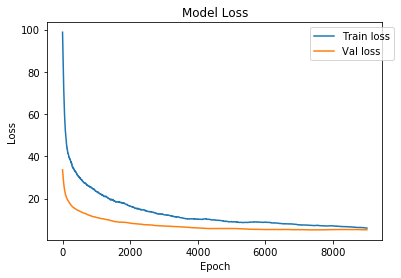

In [29]:
#Plot Model Loss

w = 1000
h1 = np.array(history.history['loss'])
h4 = np.array(history.history['val_loss'])
h1 = moving_average(h1,w)
h4 = moving_average(h4,w)
plt.plot(h1,label='Train loss')
plt.plot(h4,label='Val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

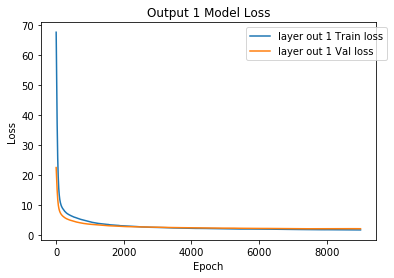

In [30]:
#Plot output 1 loss

h2 = np.array(history.history['out1_loss'])
h5 = np.array(history.history['val_out1_loss'])
h2 = moving_average(h2,w)
h5 = moving_average(h5,w)
plt.plot(h2,label='layer out 1 Train loss')
plt.plot(h5,label='layer out 1 Val loss')
plt.title('Output 1 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

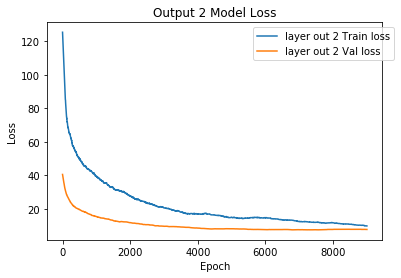

In [31]:
#Plot output 2 loss

h3 = np.array(history.history['out2_loss'])
h6 = np.array(history.history['val_out2_loss'])
h3 = moving_average(h3,w)
h6 = moving_average(h6,w)
plt.plot(h3,label='layer out 2 Train loss')
plt.plot(h6,label='layer out 2 Val loss')
plt.title('Output 2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

In [32]:
#Load ground truth RUL

thr = mat['thr']
fleet_NUM = np.arange(0,pad,1)

rul = pd.read_csv(rul_file,index_col=False)
rul = (rul-1)/(thr-1)
rul_Fleet_All = np.zeros(100)
for x in range(100):
    rul_Fleet_All[x] = rul['RUL'][x]
rul_Fleet_All_Full = ((thr-1)*rul_Fleet_All) + 1
rul_Fleet_All_Full

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 28., 50., 16., 50., 50., 50., 20., 50., 50.,
       50., 50., 50., 50.,  8., 48., 50.,  7., 11., 19., 21., 50., 50.,
       28., 18., 10., 50., 50., 50., 47., 50., 50., 21., 50., 50., 29.,
       26., 50., 50., 15., 50., 37., 50., 50., 21., 50., 50., 28., 50.,
       14., 50.,  8., 50., 50., 50., 50., 50., 50., 50., 10., 34., 50.,
       50., 50.,  8.,  9., 50., 50., 50., 50., 50., 50., 50., 28., 38.,
       20., 50., 50., 50., 50., 50., 50., 50., 20.])

In [33]:
#Make 100 predictions and calculate average performance

import sklearn
import math
from sklearn import metrics

rmse = np.zeros(100)
rmse1 = np.zeros(100)
sc = np.zeros(100)
sc1 = np.zeros(100)

for i in range(100):
    
    preds = model(x_test)
    tens_draw = preds[0].sample(1000)
    tens_draw1 = preds[1].sample(1000)
    tens_draw = tf.keras.backend.get_value(tens_draw)
    tens_draw1 = tf.keras.backend.get_value(tens_draw1)

    #RMSE with AU

    mean_Fleet_All = np.zeros(tens_draw.shape[1])
    mean_Fleet = np.zeros(tens_draw.shape[0])
    for y in range(tens_draw.shape[1]):
        for x in range(tens_draw.shape[0]):
            mean_Fleet[x] = tens_draw[x,y,0]
        mean_Fleet_All[y] = mean_Fleet.mean()

    RUL_mse = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All)
    RUL_rmse = math.sqrt(RUL_mse)
    rmse[i] = RUL_rmse

    #RMSE with EU

    mean_Fleet_All1 = np.zeros(tens_draw1.shape[1])
    mean_Fleet1 = np.zeros(tens_draw1.shape[0])
    for y in range(tens_draw1.shape[1]):
        for x in range(tens_draw1.shape[0]):
            mean_Fleet1[x] = tens_draw1[x,y,0]
        mean_Fleet_All1[y] = mean_Fleet1.mean()

    RUL_mse1 = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All1)
    RUL_rmse1 = math.sqrt(RUL_mse1)
    rmse1[i] = RUL_rmse1
    
    score = mean_Fleet_All-rul_Fleet_All_Full

    for j in range(100):
        if score[j]<0:
            score[j]= math.exp((-score[j])/13)-1
        else:
            score[j] = math.exp(score[j]/10)-1
    
    sc[i] = np.sum(score)
    
    score1 = mean_Fleet_All1-rul_Fleet_All_Full

    for j in range(100):
        if score1[j]<0:
            score1[j]= math.exp((-score1[j])/13)-1
        else:
            score1[j] = math.exp(score1[j]/10)-1
    
    sc1[i] = np.sum(score1)

In [34]:
#Average RMSE with AU & EU
np.mean(rmse),np.mean(rmse1)

(14.592068207922457, 15.86861916049702)

In [35]:
#Average score with AU & EU
np.mean(sc),np.mean(sc1)

(431.98782656881144, 594.8762890351064)

In [36]:
#Calculate Mean & Std of prediction with AU

Fleet = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean = pd.DataFrame(np.zeros((pad,1)))
std = pd.DataFrame(np.zeros((pad,1)))
for y in range(tens_draw1.shape[0]):
    Fleet[y] = tens_draw[y][0]
    row_Mean = Fleet.mean(axis=1)
    row_Std = Fleet.std(axis=1)
    for j in range(pad):
        mean[0][j] = row_Mean[j]
    for k in range(pad):
        std[0][k] = row_Std[k]

In [37]:
#Calculate Mean & Std of prediction with EU

Fleet1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean1 = pd.DataFrame(np.zeros((pad,1)))
std1 = pd.DataFrame(np.zeros((pad,1)))
for y in range(tens_draw1.shape[0]):
    Fleet1[y] = tens_draw1[y][0]
    row_Mean = Fleet1.mean(axis=1)
    row_Std = Fleet1.std(axis=1)
    for j in range(pad):
        mean1[0][j] = row_Mean[j]
    for k in range(pad):
        std1[0][k] = row_Std[k]

In [38]:
#Load ground truth RUL

fleet_RUL = pd.read_csv(fleet_Rul_File, skiprows = 0,header = None)

In [39]:
max_RUL_Arrange = pd.DataFrame(np.zeros((100,2)))
for x in range(100):
    max_RUL_Arrange[0][x] = fleet_NUM[x]
    max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[0][x]) + 1
max_RUL_Arrange.columns = ['Cycle','RUL']

Using matplotlib backend: Qt5Agg


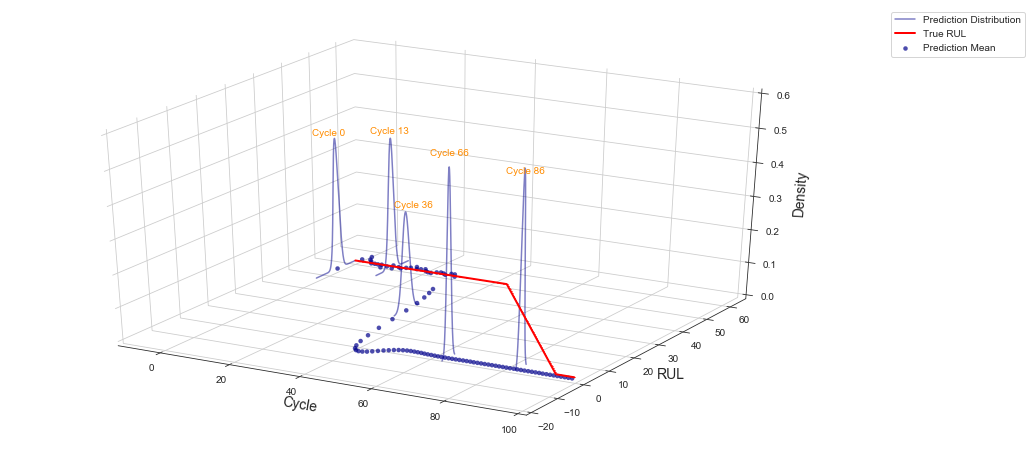

In [40]:
#3d visualization of prediction
%matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.stats import norm

sns.set_style('ticks')

%matplotlib inline
plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-10, 100)
ax.set_ylim3d(-20, 65)
ax.set_zlim3d(0, 0.6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Cycle',fontsize='14')
ax.set_ylabel('RUL',fontsize='14')
ax.set_zlabel('Density',fontsize='14')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


s = np.arange(0,100,1)

i = 0
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01,label = "Prediction")
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i]),color = 'darkblue', label = "Prediction Distribution", alpha=0.5)

i = 12
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i]),color = 'darkblue', alpha=0.5)

i = 35
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i],std[0][i]),color = 'darkblue',alpha=0.5)

i = 65
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i],std[0][i]),color = 'darkblue',alpha=0.5)

i = 85
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i],std[0][i]),color = 'darkblue',alpha=0.5)

ax.scatter3D(s,mean[0][0:100],linewidth=0.03,marker="o",color = "darkblue", alpha=0.7,label='Prediction Mean')
ax.plot3D(s,max_RUL_Arrange['RUL'],linewidth=2,marker="_",markersize=1,color = 'r',label='True RUL')

ax.text(-8, 45, 0.39, "Cycle 0", color='darkorange')
ax.text(9, 45, 0.42, "Cycle 13", color='darkorange')
ax.text(31, 25, 0.30, "Cycle 36", color='darkorange')
ax.text(60, 0, 0.58, "Cycle 66", color='darkorange')
ax.text(80, 0, 0.56, "Cycle 86", color='darkorange')

plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
#ax.view_init(0, 45)
plt.show()

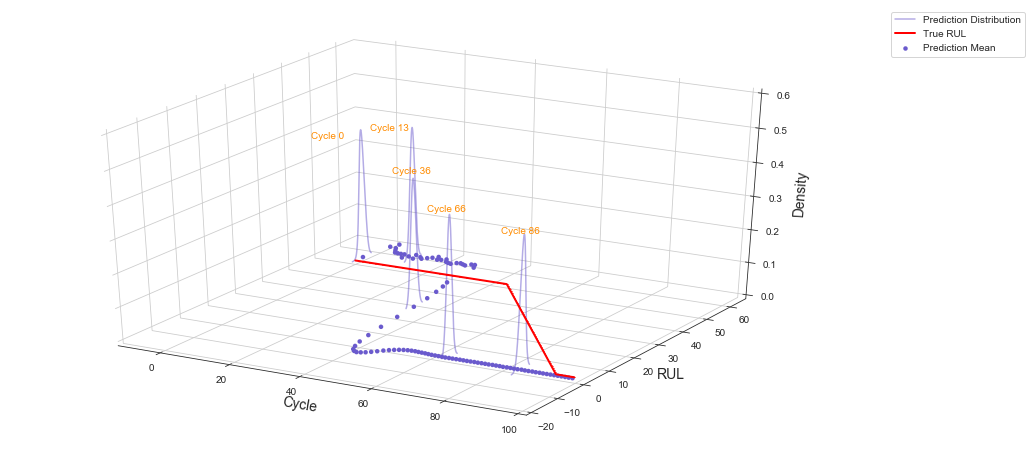

In [41]:
sns.set_style('ticks')

%matplotlib inline
plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-10, 100)
ax.set_ylim3d(-20, 65)
ax.set_zlim3d(0, 0.6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Cycle',fontsize='14')
ax.set_ylabel('RUL',fontsize='14')
ax.set_zlabel('Density',fontsize='14')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

s = np.arange(0,100,1)

i = 0
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35,label='Prediction')
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5, label="Prediction Distribution")

i = 12
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

i = 35
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

i = 65
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

i = 85
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

ax.scatter3D(s,mean1[0][0:100],linewidth=0.03,marker="o",color = 'slateblue',alpha=1,label='Prediction Mean')
ax.plot3D(s,max_RUL_Arrange['RUL'],linewidth=2,marker="_",markersize=1,color = 'r',label='True RUL')

ax.text(-8.5, 45, 0.38, "Cycle 0", color='darkorange')
ax.text(9, 45, 0.43, "Cycle 13", color='darkorange')
ax.text(30.5, 25, 0.40, "Cycle 36", color='darkorange')
ax.text(59, 0, 0.42, "Cycle 66", color='darkorange')
ax.text(79, 0, 0.39, "Cycle 86", color='darkorange')

plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.show()

In [42]:
cycle_lim = np.zeros(100)
S = 0
for K in range(100):
    for L in range(pad):
        if fleet_RUL[K][L] == 0:
            S = 0
            break
        else:
            S = S + 1
            cycle_lim[K] = S

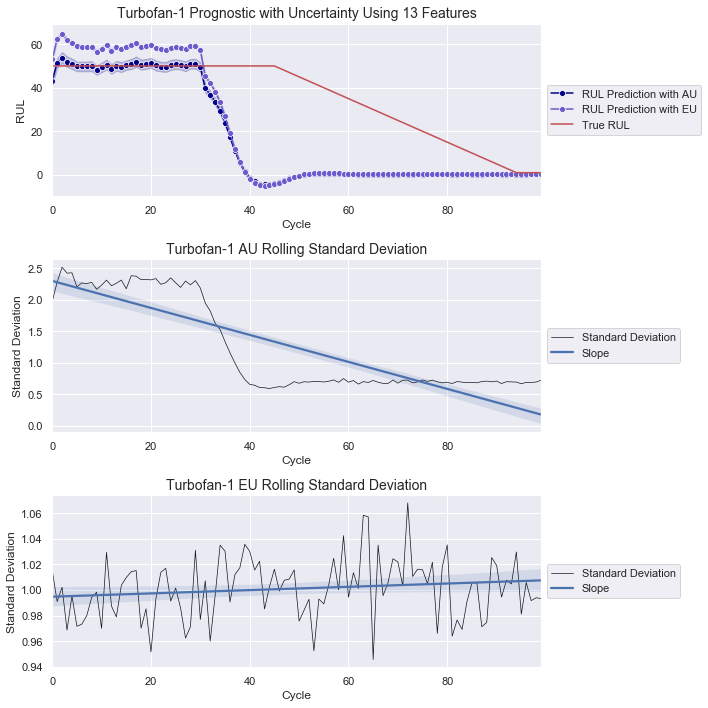

In [43]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set()
for B in range(0,1):
    lim = 100#int(cycle_lim[B]+1)
    lim2 = 100#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    plt.title('Turbofan-%i Prognostic with Uncertainty Using 13 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

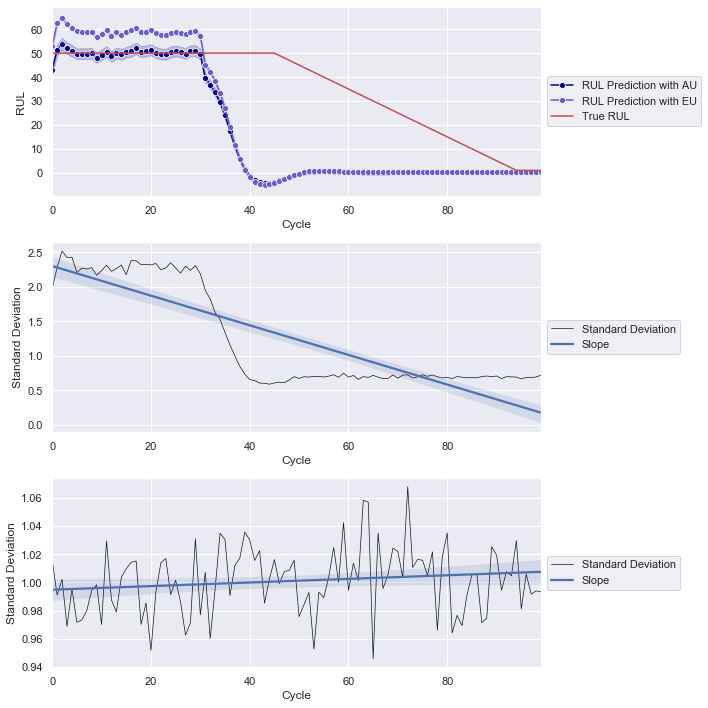

In [44]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set()
for B in range(0,1):
    lim = 100#int(cycle_lim[B]+1)
    lim2 = 100#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    #plt.title('Turbofan-%i Prognostic with Uncertainty Using 13 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

In [45]:
#Calculate Mean & Std of prediction Turbofan 18 with AU

Fleet3 = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean3 = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
std3 = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
for y in range(1000):
    Fleet3[y] = tens_draw[y][17]
    row_Mean = Fleet3.mean(axis=1)
    row_Std = Fleet3.std(axis=1)
    for j in range(pad):
        mean3[0][j] = row_Mean[j]
    for k in range(pad):
        std3[0][k] = row_Std[k]

In [46]:
#Calculate Mean & Std of prediction Turbofan 18 with EU

Fleet4 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean4 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
std4 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
for y in range(tens_draw1.shape[0]):
    Fleet4[y] = tens_draw1[y][17]
    row_Mean = Fleet4.mean(axis=1)
    row_Std = Fleet4.std(axis=1)
    for j in range(pad):
        mean4[0][j] = row_Mean[j]
    for k in range(pad):
        std4[0][k] = row_Std[k]

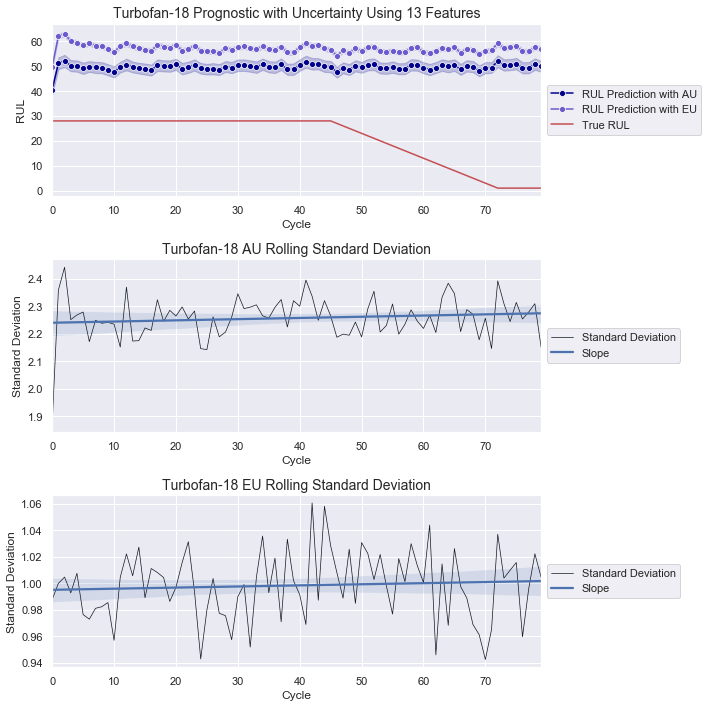

In [47]:
#Visualization Fleet 18

sns.set()
for B in range(17,18):
    lim = 80#int(cycle_lim[B]+1)
    lim2 = 80#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std3[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std4[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    plt.title('Turbofan-%i Prognostic with Uncertainty Using 13 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

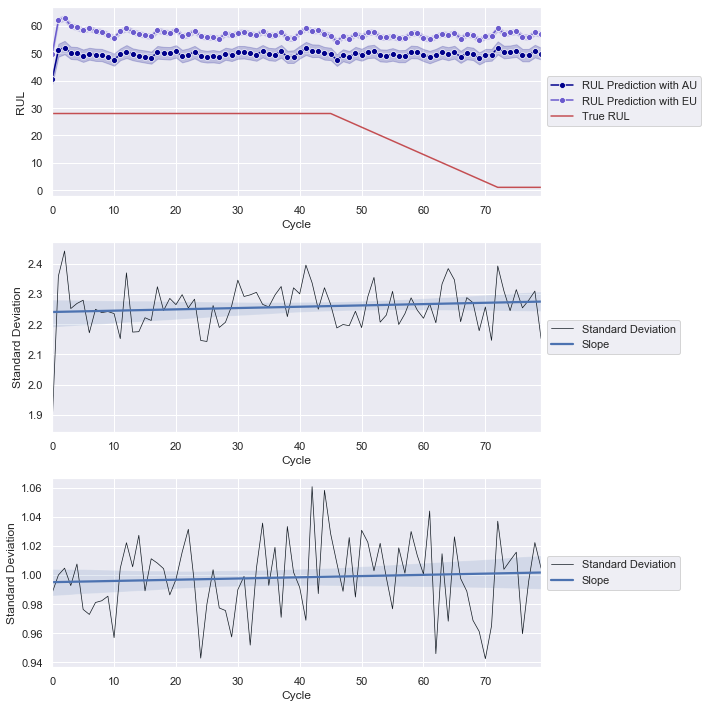

In [48]:
#Visualization Fleet 18

sns.set()
for B in range(17,18):
    lim = 80#int(cycle_lim[B]+1)
    lim2 = 80#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std3[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std4[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    #plt.title('Turbofan-%i Prognostic with Uncertainty Using 13 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [49]:
#Explanation
inputs = tf.keras.Input(shape=(303,13),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)
layer3 = Dense(1)(layer2)
layer4 = Lambda(lambda t: t[:,-1],name='out2')(layer3)
model2 = tf.keras.Model(inputs=inputs, outputs=layer4)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 303, 13)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 303, 25)           3900      
_________________________________________________________________
dense_2 (Dense)              (None, 303, 213)          5538      
_________________________________________________________________
dense_3 (Dense)              (None, 303, 1)            214       
_________________________________________________________________
out2 (Lambda)                (None, 1)                 0         
Total params: 9,652
Trainable params: 9,652
Non-trainable params: 0
_________________________________________________________________


In [50]:
a = model.layers[3].get_weights()

b = np.zeros((len(a[0]),1))
for x in range(len(a[0])):
    b[x] = a[0][x][0]
    
d = np.zeros(1)
for x in range(1):
    d[x] = a[1][x]
    
c = [b,d]

In [51]:
#Transfer weights from old LSTM to new LSTM

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[3].set_weights(c)

In [52]:
preds2 = model2(x_test)
y3 = preds2
y3 = tf.keras.backend.get_value(y3)
tens_draw3 = y3

In [53]:
import shap
shap.initjs()

In [54]:
features = pd.read_csv(train_file, index_col=False)
features = features.drop(['Fleet','Cycle','RUL'],axis=1)
features = np.array(list(features.columns))
features

array(['OC1', 'OC2', 'OC3', 'S2', 'S4', 'S7', 'S8', 'S11', 'S12', 'S13',
       'S15', 'S20', 'S21'], dtype='<U3')

In [55]:
xtrain = pd.read_csv(train_file, index_col=False)
xtrain = xtrain.drop(['Fleet','Cycle','RUL'],axis=1)

In [56]:
#SHAP Summmary Plot
instance = x_train
instance2 = x_test
explainer = shap.DeepExplainer(model2,instance)
shap_values = explainer.shap_values(instance2)

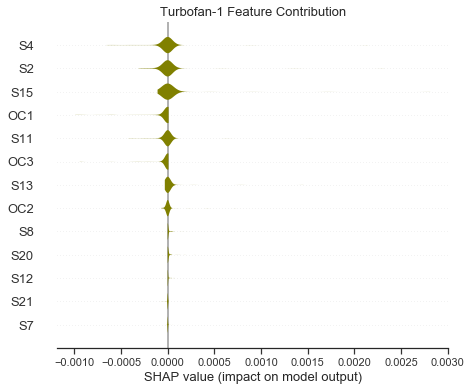

In [57]:
# SHAP Summmary Plot Turbofan 1
sns.set_style("ticks")
for i in range(0,1):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(7,6),plot_type="violin", color='olive')
    plt.title("Turbofan-%i Feature Contribution" %(i+1),fontsize=13)
    #plt.savefig("Sum_Plot %i" %i+'.png')
    #plt.figure

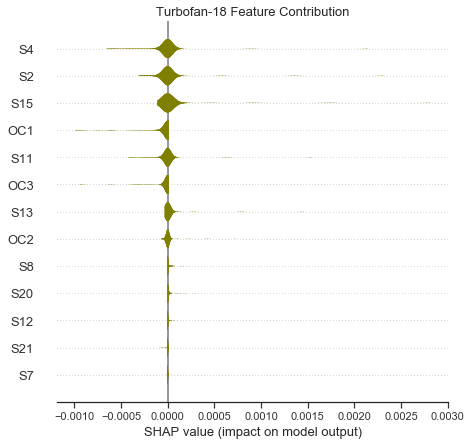

In [58]:
# SHAP Summmary Plot Turbofan 18
for i in range(13,18):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(7,7),plot_type="violin", color='olive')
    plt.title("Turbofan-%i Feature Contribution" %(i+1),fontsize=13)

In [59]:
#SHAP Force Plot Turbofan 1

sns.set_style("ticks")
for s in range(0,1):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    # Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,13),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

1 1


1 2


1 3


1 4


1 5


1 6


1 7


1 8


1 9


1 10


1 11


1 12


1 13


1 14


1 15


1 16


1 17


1 18


1 19


1 20


1 21


1 22


1 23


1 24


1 25


1 26


1 27


1 28


1 29


1 30


1 31


1 32


1 33


1 34


1 35


1 36


1 37


1 38


1 39


1 40


1 41


1 42


1 43


1 44


1 45


1 46


1 47


1 48


1 49


1 50


1 51


1 52


1 53


1 54


1 55


1 56


1 57


1 58


1 59


1 60


1 61


1 62


1 63


1 64


1 65


1 66


1 67


1 68


1 69


1 70


1 71


1 72


1 73


1 74


1 75


1 76


1 77


1 78


1 79


1 80


1 81


1 82


1 83


1 84


1 85


1 86


1 87


1 88


1 89


1 90


1 91


1 92


1 93


1 94


1 95


1 96


1 97


1 98


1 99


1 100


1 101


1 102


1 103


1 104


1 105


1 106


1 107


1 108


1 109


1 110


1 111


1 112


1 113


1 114


1 115


1 116


1 117


1 118


1 119


1 120


1 121


1 122


1 123


1 124


1 125


1 126


1 127


1 128


1 129


1 130


1 131


1 132


1 133


1 134


1 135


1 136


1 137


1 138


1 139


1 140


1 141


1 142


1 143


1 144


1 145


1 146


1 147


1 148


1 149


1 150


1 151


1 152


1 153


1 154


1 155


1 156


1 157


1 158


1 159


1 160


1 161


1 162


1 163


1 164


1 165


1 166


1 167


1 168


1 169


1 170


1 171


1 172


1 173


1 174


1 175


1 176


1 177


1 178


1 179


1 180


1 181


1 182


1 183


1 184


1 185


1 186


1 187


1 188


1 189


1 190


1 191


1 192


1 193


1 194


1 195


1 196


1 197


1 198


1 199


1 200


1 201


1 202


1 203


1 204


1 205


1 206


1 207


1 208


1 209


1 210


1 211


1 212


1 213


1 214


1 215


1 216


1 217


1 218


1 219


1 220


1 221


1 222


1 223


1 224


1 225


1 226


1 227


1 228


1 229


1 230


1 231


1 232


1 233


1 234


1 235


1 236


1 237


1 238


1 239


1 240


1 241


1 242


1 243


1 244


1 245


1 246


1 247


1 248


1 249


1 250


1 251


1 252


1 253


1 254


1 255


1 256


1 257


1 258


1 259


1 260


1 261


1 262


1 263


1 264


1 265


1 266


1 267


1 268


1 269


1 270


1 271


1 272


1 273


1 274


1 275


1 276


1 277


1 278


1 279


1 280


1 281


1 282


1 283


1 284


1 285


1 286


1 287


1 288


1 289


1 290


1 291


1 292


1 293


1 294


1 295


1 296


1 297


1 298


1 299


1 300


1 301


1 302


1 303


In [60]:
#SHAP Force Plot Turbofan 18

for s in range(13,18):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    # Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,13),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

14 1


14 2


14 3


14 4


14 5


14 6


14 7


14 8


14 9


14 10


14 11


14 12


14 13


14 14


14 15


14 16


14 17


14 18


14 19


14 20


14 21


14 22


14 23


14 24


14 25


14 26


14 27


14 28


14 29


14 30


14 31


14 32


14 33


14 34


14 35


14 36


14 37


14 38


14 39


14 40


14 41


14 42


14 43


14 44


14 45


14 46


14 47


14 48


14 49


14 50


14 51


14 52


14 53


14 54


14 55


14 56


14 57


14 58


14 59


14 60


14 61


14 62


14 63


14 64


14 65


14 66


14 67


14 68


14 69


14 70


14 71


14 72


14 73


14 74


14 75


14 76


14 77


14 78


14 79


14 80


14 81


14 82


14 83


14 84


14 85


14 86


14 87


14 88


14 89


14 90


14 91


14 92


14 93


14 94


14 95


14 96


14 97


14 98


14 99


14 100


14 101


14 102


14 103


14 104


14 105


14 106


14 107


14 108


14 109


14 110


14 111


14 112


14 113


14 114


14 115


14 116


14 117


14 118


14 119


14 120


14 121


14 122


14 123


14 124


14 125


14 126


14 127


14 128


14 129


14 130


14 131


14 132


14 133


14 134


14 135


14 136


14 137


14 138


14 139


14 140


14 141


14 142


14 143


14 144


14 145


14 146


14 147


14 148


14 149


14 150


14 151


14 152


14 153


14 154


14 155


14 156


14 157


14 158


14 159


14 160


14 161


14 162


14 163


14 164


14 165


14 166


14 167


14 168


14 169


14 170


14 171


14 172


14 173


14 174


14 175


14 176


14 177


14 178


14 179


14 180


14 181


14 182


14 183


14 184


14 185


14 186


14 187


14 188


14 189


14 190


14 191


14 192


14 193


14 194


14 195


14 196


14 197


14 198


14 199


14 200


14 201


14 202


14 203


14 204


14 205


14 206


14 207


14 208


14 209


14 210


14 211


14 212


14 213


14 214


14 215


14 216


14 217


14 218


14 219


14 220


14 221


14 222


14 223


14 224


14 225


14 226


14 227


14 228


14 229


14 230


14 231


14 232


14 233


14 234


14 235


14 236


14 237


14 238


14 239


14 240


14 241


14 242


14 243


14 244


14 245


14 246


14 247


14 248


14 249


14 250


14 251


14 252


14 253


14 254


14 255


14 256


14 257


14 258


14 259


14 260


14 261


14 262


14 263


14 264


14 265


14 266


14 267


14 268


14 269


14 270


14 271


14 272


14 273


14 274


14 275


14 276


14 277


14 278


14 279


14 280


14 281


14 282


14 283


14 284


14 285


14 286


14 287


14 288


14 289


14 290


14 291


14 292


14 293


14 294


14 295


14 296


14 297


14 298


14 299


14 300


14 301


14 302


14 303


15 1


15 2


15 3


15 4


15 5


15 6


15 7


15 8


15 9


15 10


15 11


15 12


15 13


15 14


15 15


15 16


15 17


15 18


15 19


15 20


15 21


15 22


15 23


15 24


15 25


15 26


15 27


15 28


15 29


15 30


15 31


15 32


15 33


15 34


15 35


15 36


15 37


15 38


15 39


15 40


15 41


15 42


15 43


15 44


15 45


15 46


15 47


15 48


15 49


15 50


15 51


15 52


15 53


15 54


15 55


15 56


15 57


15 58


15 59


15 60


15 61


15 62


15 63


15 64


15 65


15 66


15 67


15 68


15 69


15 70


15 71


15 72


15 73


15 74


15 75


15 76


15 77


15 78


15 79


15 80


15 81


15 82


15 83


15 84


15 85


15 86


15 87


15 88


15 89


15 90


15 91


15 92


15 93


15 94


15 95


15 96


15 97


15 98


15 99


15 100


15 101


15 102


15 103


15 104


15 105


15 106


15 107


15 108


15 109


15 110


15 111


15 112


15 113


15 114


15 115


15 116


15 117


15 118


15 119


15 120


15 121


15 122


15 123


15 124


15 125


15 126


15 127


15 128


15 129


15 130


15 131


15 132


15 133


15 134


15 135


15 136


15 137


15 138


15 139


15 140


15 141


15 142


15 143


15 144


15 145


15 146


15 147


15 148


15 149


15 150


15 151


15 152


15 153


15 154


15 155


15 156


15 157


15 158


15 159


15 160


15 161


15 162


15 163


15 164


15 165


15 166


15 167


15 168


15 169


15 170


15 171


15 172


15 173


15 174


15 175


15 176


15 177


15 178


15 179


15 180


15 181


15 182


15 183


15 184


15 185


15 186


15 187


15 188


15 189


15 190


15 191


15 192


15 193


15 194


15 195


15 196


15 197


15 198


15 199


15 200


15 201


15 202


15 203


15 204


15 205


15 206


15 207


15 208


15 209


15 210


15 211


15 212


15 213


15 214


15 215


15 216


15 217


15 218


15 219


15 220


15 221


15 222


15 223


15 224


15 225


15 226


15 227


15 228


15 229


15 230


15 231


15 232


15 233


15 234


15 235


15 236


15 237


15 238


15 239


15 240


15 241


15 242


15 243


15 244


15 245


15 246


15 247


15 248


15 249


15 250


15 251


15 252


15 253


15 254


15 255


15 256


15 257


15 258


15 259


15 260


15 261


15 262


15 263


15 264


15 265


15 266


15 267


15 268


15 269


15 270


15 271


15 272


15 273


15 274


15 275


15 276


15 277


15 278


15 279


15 280


15 281


15 282


15 283


15 284


15 285


15 286


15 287


15 288


15 289


15 290


15 291


15 292


15 293


15 294


15 295


15 296


15 297


15 298


15 299


15 300


15 301


15 302


15 303


16 1


16 2


16 3


16 4


16 5


16 6


16 7


16 8


16 9


16 10


16 11


16 12


16 13


16 14


16 15


16 16


16 17


16 18


16 19


16 20


16 21


16 22


16 23


16 24


16 25


16 26


16 27


16 28


16 29


16 30


16 31


16 32


16 33


16 34


16 35


16 36


16 37


16 38


16 39


16 40


16 41


16 42


16 43


16 44


16 45


16 46


16 47


16 48


16 49


16 50


16 51


16 52


16 53


16 54


16 55


16 56


16 57


16 58


16 59


16 60


16 61


16 62


16 63


16 64


16 65


16 66


16 67


16 68


16 69


16 70


16 71


16 72


16 73


16 74


16 75


16 76


16 77


16 78


16 79


16 80


16 81


16 82


16 83


16 84


16 85


16 86


16 87


16 88


16 89


16 90


16 91


16 92


16 93


16 94


16 95


16 96


16 97


16 98


16 99


16 100


16 101


16 102


16 103


16 104


16 105


16 106


16 107


16 108


16 109


16 110


16 111


16 112


16 113


16 114


16 115


16 116


16 117


16 118


16 119


16 120


16 121


16 122


16 123


16 124


16 125


16 126


16 127


16 128


16 129


16 130


16 131


16 132


16 133


16 134


16 135


16 136


16 137


16 138


16 139


16 140


16 141


16 142


16 143


16 144


16 145


16 146


16 147


16 148


16 149


16 150


16 151


16 152


16 153


16 154


16 155


16 156


16 157


16 158


16 159


16 160


16 161


16 162


16 163


16 164


16 165


16 166


16 167


16 168


16 169


16 170


16 171


16 172


16 173


16 174


16 175


16 176


16 177


16 178


16 179


16 180


16 181


16 182


16 183


16 184


16 185


16 186


16 187


16 188


16 189


16 190


16 191


16 192


16 193


16 194


16 195


16 196


16 197


16 198


16 199


16 200


16 201


16 202


16 203


16 204


16 205


16 206


16 207


16 208


16 209


16 210


16 211


16 212


16 213


16 214


16 215


16 216


16 217


16 218


16 219


16 220


16 221


16 222


16 223


16 224


16 225


16 226


16 227


16 228


16 229


16 230


16 231


16 232


16 233


16 234


16 235


16 236


16 237


16 238


16 239


16 240


16 241


16 242


16 243


16 244


16 245


16 246


16 247


16 248


16 249


16 250


16 251


16 252


16 253


16 254


16 255


16 256


16 257


16 258


16 259


16 260


16 261


16 262


16 263


16 264


16 265


16 266


16 267


16 268


16 269


16 270


16 271


16 272


16 273


16 274


16 275


16 276


16 277


16 278


16 279


16 280


16 281


16 282


16 283


16 284


16 285


16 286


16 287


16 288


16 289


16 290


16 291


16 292


16 293


16 294


16 295


16 296


16 297


16 298


16 299


16 300


16 301


16 302


16 303


17 1


17 2


17 3


17 4


17 5


17 6


17 7


17 8


17 9


17 10


17 11


17 12


17 13


17 14


17 15


17 16


17 17


17 18


17 19


17 20


17 21


17 22


17 23


17 24


17 25


17 26


17 27


17 28


17 29


17 30


17 31


17 32


17 33


17 34


17 35


17 36


17 37


17 38


17 39


17 40


17 41


17 42


17 43


17 44


17 45


17 46


17 47


17 48


17 49


17 50


17 51


17 52


17 53


17 54


17 55


17 56


17 57


17 58


17 59


17 60


17 61


17 62


17 63


17 64


17 65


17 66


17 67


17 68


17 69


17 70


17 71


17 72


17 73


17 74


17 75


17 76


17 77


17 78


17 79


17 80


17 81


17 82


17 83


17 84


17 85


17 86


17 87


17 88


17 89


17 90


17 91


17 92


17 93


17 94


17 95


17 96


17 97


17 98


17 99


17 100


17 101


17 102


17 103


17 104


17 105


17 106


17 107


17 108


17 109


17 110


17 111


17 112


17 113


17 114


17 115


17 116


17 117


17 118


17 119


17 120


17 121


17 122


17 123


17 124


17 125


17 126


17 127


17 128


17 129


17 130


17 131


17 132


17 133


17 134


17 135


17 136


17 137


17 138


17 139


17 140


17 141


17 142


17 143


17 144


17 145


17 146


17 147


17 148


17 149


17 150


17 151


17 152


17 153


17 154


17 155


17 156


17 157


17 158


17 159


17 160


17 161


17 162


17 163


17 164


17 165


17 166


17 167


17 168


17 169


17 170


17 171


17 172


17 173


17 174


17 175


17 176


17 177


17 178


17 179


17 180


17 181


17 182


17 183


17 184


17 185


17 186


17 187


17 188


17 189


17 190


17 191


17 192


17 193


17 194


17 195


17 196


17 197


17 198


17 199


17 200


17 201


17 202


17 203


17 204


17 205


17 206


17 207


17 208


17 209


17 210


17 211


17 212


17 213


17 214


17 215


17 216


17 217


17 218


17 219


17 220


17 221


17 222


17 223


17 224


17 225


17 226


17 227


17 228


17 229


17 230


17 231


17 232


17 233


17 234


17 235


17 236


17 237


17 238


17 239


17 240


17 241


17 242


17 243


17 244


17 245


17 246


17 247


17 248


17 249


17 250


17 251


17 252


17 253


17 254


17 255


17 256


17 257


17 258


17 259


17 260


17 261


17 262


17 263


17 264


17 265


17 266


17 267


17 268


17 269


17 270


17 271


17 272


17 273


17 274


17 275


17 276


17 277


17 278


17 279


17 280


17 281


17 282


17 283


17 284


17 285


17 286


17 287


17 288


17 289


17 290


17 291


17 292


17 293


17 294


17 295


17 296


17 297


17 298


17 299


17 300


17 301


17 302


17 303


18 1


18 2


18 3


18 4


18 5


18 6


18 7


18 8


18 9


18 10


18 11


18 12


18 13


18 14


18 15


18 16


18 17


18 18


18 19


18 20


18 21


18 22


18 23


18 24


18 25


18 26


18 27


18 28


18 29


18 30


18 31


18 32


18 33


18 34


18 35


18 36


18 37


18 38


18 39


18 40


18 41


18 42


18 43


18 44


18 45


18 46


18 47


18 48


18 49


18 50


18 51


18 52


18 53


18 54


18 55


18 56


18 57


18 58


18 59


18 60


18 61


18 62


18 63


18 64


18 65


18 66


18 67


18 68


18 69


18 70


18 71


18 72


18 73


18 74


18 75


18 76


18 77


18 78


18 79


18 80


18 81


18 82


18 83


18 84


18 85


18 86


18 87


18 88


18 89


18 90


18 91


18 92


18 93


18 94


18 95


18 96


18 97


18 98


18 99


18 100


18 101


18 102


18 103


18 104


18 105


18 106


18 107


18 108


18 109


18 110


18 111


18 112


18 113


18 114


18 115


18 116


18 117


18 118


18 119


18 120


18 121


18 122


18 123


18 124


18 125


18 126


18 127


18 128


18 129


18 130


18 131


18 132


18 133


18 134


18 135


18 136


18 137


18 138


18 139


18 140


18 141


18 142


18 143


18 144


18 145


18 146


18 147


18 148


18 149


18 150


18 151


18 152


18 153


18 154


18 155


18 156


18 157


18 158


18 159


18 160


18 161


18 162


18 163


18 164


18 165


18 166


18 167


18 168


18 169


18 170


18 171


18 172


18 173


18 174


18 175


18 176


18 177


18 178


18 179


18 180


18 181


18 182


18 183


18 184


18 185


18 186


18 187


18 188


18 189


18 190


18 191


18 192


18 193


18 194


18 195


18 196


18 197


18 198


18 199


18 200


18 201


18 202


18 203


18 204


18 205


18 206


18 207


18 208


18 209


18 210


18 211


18 212


18 213


18 214


18 215


18 216


18 217


18 218


18 219


18 220


18 221


18 222


18 223


18 224


18 225


18 226


18 227


18 228


18 229


18 230


18 231


18 232


18 233


18 234


18 235


18 236


18 237


18 238


18 239


18 240


18 241


18 242


18 243


18 244


18 245


18 246


18 247


18 248


18 249


18 250


18 251


18 252


18 253


18 254


18 255


18 256


18 257


18 258


18 259


18 260


18 261


18 262


18 263


18 264


18 265


18 266


18 267


18 268


18 269


18 270


18 271


18 272


18 273


18 274


18 275


18 276


18 277


18 278


18 279


18 280


18 281


18 282


18 283


18 284


18 285


18 286


18 287


18 288


18 289


18 290


18 291


18 292


18 293


18 294


18 295


18 296


18 297


18 298


18 299


18 300


18 301


18 302


18 303
